# Understanding PyTorch through Image Classification

This practical is an introduction to PyTorch by developing a simple image classification model using the MNIST dataset.

The goal is to classify handwritten digits (0–9) by:
- Loading and exploring the dataset
- Creating a neural network from scratch using PyTorch
- Training and evaluating the model
- Testing the model's performance

The practical will involve the following :
- The PyTorch workflow: datasets, dataloaders, models, training, and evaluation
- How neural networks learn using backpropagation and loss optimization
- How to structure PyTorch projects for real-world use cases


## Step 1.1: Explore the Raw MNIST Dataset

Before we prepare the data for training, it's important to understand what the MNIST dataset looks like.
I will load the MNIST dataset from the `digit-recognizer` in kaggle  competition's built-in CSV files.

- `train.csv` 
- Each row has a `label` column and 784 pixel values (one per pixel).
- I will visualize a few samples to understand the data structure.


This helps build intuition about the input our neural network will learn from.


In [3]:
# Download the MNIST training set

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [5]:
# Display dataset shape and preview
print(f"Dataset shape: {df.shape}")

Dataset shape: (42000, 785)


In [6]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Extract images and labels
labels = df['label'].values
images = df.drop('label', axis=1).values

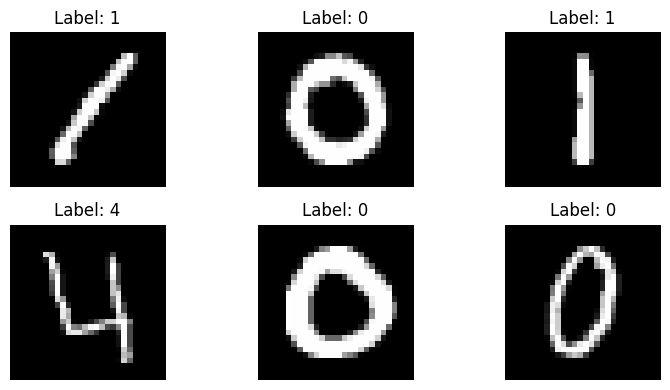

In [9]:
# Visualize the first 6 digits
plt.figure(figsize=(8, 4))
for i in range(6):
    image = images[i].reshape(28, 28)  # Reshape flat vector to 28x28 image
    plt.subplot(2, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Step 1.2: Convert Data to PyTorch Tensors and Create DataLoaders

To train a model in PyTorch, we need to:
- Convert the raw image pixel data from the CSV into `torch.Tensor` format
- Normalize pixel values to the range [0, 1]
- Create a PyTorch `TensorDataset` and wrap it in a `DataLoader` for batching and shuffling
}

In [12]:

import torch
from torch.utils.data import TensorDataset, DataLoader

# Step 1: Normalize pixel values and convert to float32
images = images / 255.0  # Scale from [0, 255] to [0.0, 1.0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:

# Step 2: Convert to PyTorch tensors
X = torch.tensor(images, dtype=torch.float32)          # Shape: [N, 784]
y = torch.tensor(labels, dtype=torch.long)             # Shape: [N]

In [14]:
X,y

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 0, 1,  ..., 7, 6, 9]))

In [16]:
# Step 3: Wrap tensors in a TensorDataset
dataset = TensorDataset(X, y)
dataset

In [18]:
# Step 4: Create DataLoader for batching
trainloader = DataLoader(dataset, batch_size=64, shuffle=True)

##  Step 2: Define the Neural Network Model

Now that data is ready, we will define a basic feedforward neural network using PyTorch.

This model will:
- Flatten the 28×28 input into a 784-length vector
- Pass it through two hidden layers with ReLU activations
- Output 10 values (logits), one for each digit class (0–9)

we will use `torch.nn.Module`, which allows to organize the layers and define the forward pass.


## My Explanation of the Model Architecture

Before training the model, it is imperative to undestand how it works
---

###  What is a Feedforward Neural Network?

A feedforward neural network is the most basic type of neural network. Data flows in one direction — from the input layer, through the hidden layers, and finally to the output layer. There are no loops or memory. This makes it simple and good for tasks like image classification.


### What is `nn.Linear`?

`nn.Linear` is a fully connected (dense) layer. It takes an input, multiplies it by a weight matrix, adds a bias, and outputs a result. The input and output sizes are defined by us. 

For example, `nn.Linear(784, 128)` means we’re taking a 784-dimensional input (a flattened 28x28 image) and mapping it to a 128-dimensional output. This helps the model learn important features from the image.


###  What is `nn.ReLU()`?

ReLU stands for Rectified Linear Unit. It’s an activation function that keeps only the positive values from the previous layer (i.e., it sets all negative values to zero). This helps the network learn complex, non-linear relationships in the data. It also makes training faster and avoids problems like vanishing gradients.


### Putting it Together

In the model, we are  stacking multiple `Linear` layers with `ReLU` activations in between:

- Input (784) → Linear → ReLU
- → Linear → ReLU
- → Linear → Output (10 classes for digits 0–9)

This setup gives the model the ability to learn useful patterns from the image data and make accurate predictions.


In [19]:

import torch.nn as nn


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        # Define layers inside a Sequential block
        self.network = nn.Sequential(
            nn.Linear(784, 128),  # Input layer to first hidden layer
            nn.ReLU(),            # Activation function
            nn.Linear(128, 64),   # Second hidden layer
            nn.ReLU(),            # Activation
            nn.Linear(64, 10)     # Output layer (10 classes)
        )

    def forward(self, x):
        # Forward pass through the network
        return self.network(x)


## Step 3: Set Up the Loss Function, Optimizer, and Device

Before we can train the model, we need to define three important components:

### Loss Function

The loss function measures how far the model's predictions are from the actual labels.

We'll use `CrossEntropyLoss`, which is ideal for multi-class classification. It combines LogSoftmax and Negative Log Likelihood into one function. This loss expects the model to output raw scores (logits) ,not probabilities.


###  Optimizer

The optimizer is responsible for updating the model’s weights based on the computed loss. We'll use `Adam`, which is an adaptive optimizer. It adjusts the learning rate for each parameter and generally leads to faster and more stable training than traditional optimizers like SGD.

### Device (CPU or GPU)

If a GPU is available, we can use it to speed up training significantly. We'll check if CUDA is available and move our model to the appropriate device accordingly.


In [20]:
import torch.optim as optim
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the selected device
model = SimpleNN().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cpu


##  Step 4: Train the Model (Epoch Loop)

Now that we’ve set up our model, loss function, optimizer, and device, it's time to train the model.


### 🔄 What happens during training?

For each **epoch** ( a full pass through the training dataset), we:

1. Loop over batches from the DataLoader
2. Move inputs and labels to the selected device (CPU/GPU)
3. Perform a **forward pass** to get predictions from the model
4. Compute the **loss** between predictions and actual labels
5. Perform a **backward pass** to calculate gradients
6. Use the **optimizer** to update the model’s weights

We’ll also track the average loss per epoch to see how training is progressing.


In [29]:
# Re-initialize model if needed
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Metrics storage
loss_history = []
accuracy_history = []

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")


Epoch 1/5 | Loss: 1.4404 | Accuracy: 51.15%
Epoch 2/5 | Loss: 0.6958 | Accuracy: 77.55%
Epoch 3/5 | Loss: 0.5495 | Accuracy: 83.06%
Epoch 4/5 | Loss: 0.4796 | Accuracy: 85.56%
Epoch 5/5 | Loss: 0.4348 | Accuracy: 87.08%


##  Step 5: Evaluate the Model on the Test Set

After training, we need to evaluate how well our model performs on data it has **never seen before** — the test set.

###  Why evaluate?

Training accuracy alone doesn’t tell us if the model has learned to generalize. By testing on unseen data, we check whether the model can make correct predictions outside the training distribution.

### How we'll do it:

1. Loop through batches of the test data
2. Use the trained model to predict labels
3. Compare predictions with actual labels
4. Calculate overall accuracy

We’ll also make sure:
- We disable gradient tracking (`torch.no_grad()`) since we’re not training
- The model is in **evaluation mode** using `model.eval()`


In [27]:
# Load test.csv and normalize pixel values
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_images = test_df.values / 255.0  # Normalize

# Convert to PyTorch tensor
X_test = torch.tensor(test_images, dtype=torch.float32)

# Create DataLoader
testloader = DataLoader(X_test, batch_size=64, shuffle=False)


In [28]:
# Load test.csv and normalize pixel values
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_images = test_df.values / 255.0  # Normalize

# Convert to PyTorch tensor
X_test = torch.tensor(test_images, dtype=torch.float32)

# Create DataLoader
testloader = DataLoader(X_test, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()

# Store predictions
all_preds = []

with torch.no_grad():
    for batch in testloader:
        batch = batch.to(device)
        outputs = model(batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  # Move back to CPU

# Create submission DataFrame
submission_df = pd.DataFrame({
    "ImageId": list(range(1, len(all_preds) + 1)),
    "Label": all_preds
})

# Save to CSV (Kaggle-compatible)
submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv generated!")

✅ submission.csv generated!
